# Logistic Regression for survival
My first comepetition kernal

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

gender_submission.csv
test.csv
train.csv



## Data 

Importing the data and libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Upload our training csv to a dataframe called 'train'

In [3]:
train=pd.read_csv('../input/train.csv')

Check the basics on our training data, the header, the info, and the description

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


##  Exploratory Data Anaylsis

Lets start with a pairplot, and check for missing values

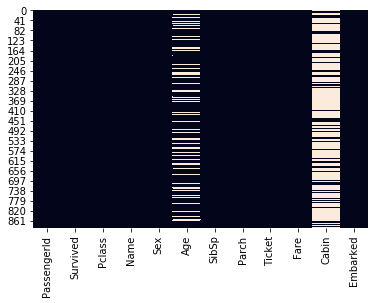

In [7]:
sns.heatmap(train.isnull(),cbar=False)

Missing lots of values in cabin so we will drop that column, and missing alot in age too. For age we can impute the average by class into the missing values

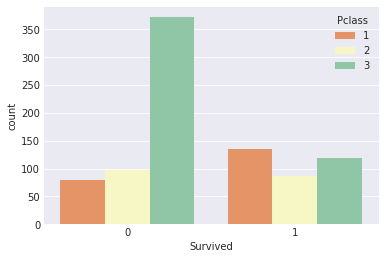

In [8]:
sns.set_style('darkgrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='Spectral')

We can see most passengers who passed were of Pclass 3, and surivors were fairly even.

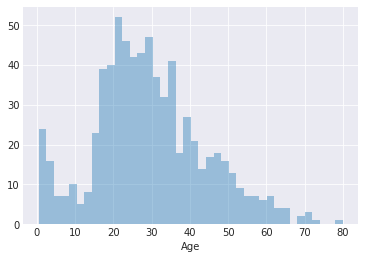

In [9]:
sns.distplot(train['Age'].dropna(),kde=False,bins=40)

Pretty normalized age dist, with the age centered around 22

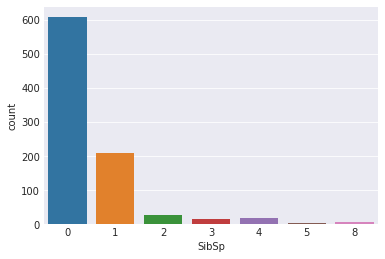

In [10]:
sns.countplot(x='SibSp',data=train)

Most people no SibSp relation

## Data Cleaning

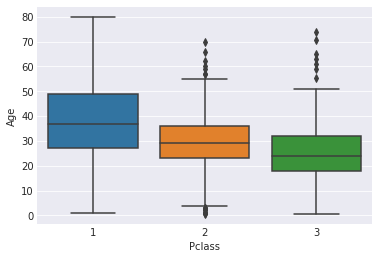

In [11]:
sns.boxplot(x='Pclass',y='Age',data=train)

We can see older age in better classes. This will be useful in the instance where we want to replace the null age value. We will drop 'Cabin' because it was essentiall all missing. We will create a new dataframe called train where we impute the average age  by class into the null values. We will also drop name, passenger Id, and ticket info becuase those dont seem useful without adding more features like NLP

In [12]:
m_1=train[train['Pclass']==1]['Age'].median()
m_2=train[train['Pclass']==2]['Age'].median()
m_3=train[train['Pclass']==3]['Age'].median()

In [13]:
def imputeage(cols):
    Age=cols[0]
    Pclass=cols[1]
    
    if pd.isnull(Age):
        if Pclass ==1:
            return m_1
        elif Pclass ==2:
            return m_2
        else:
            return m_3
        
    else:
        return Age

In [14]:
train=train.drop(['Cabin','Name','Ticket','PassengerId'],axis=1)
train['Age']=train[['Age','Pclass']].apply(imputeage,axis=1)

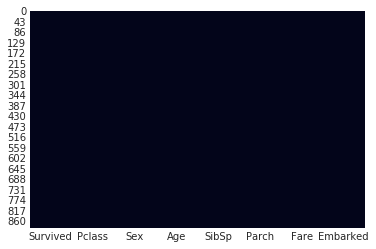

In [15]:
sns.heatmap(train.isnull(),cbar=False)

We need to conver our categorical features into dummy variable so that a log regression can understand and then replace our categorical columns with the new dummies

In [16]:
sex=pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [17]:
train.drop(['Sex','Embarked'],axis=1,inplace=True)

In [18]:
train=pd.concat([train,sex,embark],axis=1)

In [19]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


## Building our Log model using sklearn 

First we need to import Logistic Regression from sklearn and our test data, we need to format our test data so it is the same headers as above also.

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
test=pd.read_csv('../input/test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [22]:
test=test.drop(['Cabin','Name','Ticket','PassengerId'],axis=1)
test['Age']=test[['Age','Pclass']].apply(imputeage,axis=1)

In [23]:
sex=pd.get_dummies(test['Sex'],drop_first=True)
embark = pd.get_dummies(test['Embarked'],drop_first=True)

In [24]:
test.drop(['Sex','Embarked'],axis=1,inplace=True)

In [25]:
test=pd.concat([test,sex,embark],axis=1)

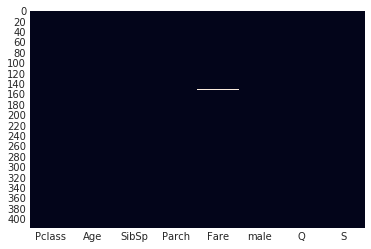

In [26]:
sns.heatmap(test.isnull(),cbar=False)

We have one null value in fair that we will replace with the average Fare price by Pclass using the same method for Age

In [27]:
fm_1=train[train['Pclass']==1]['Fare'].median()
fm_2=train[train['Pclass']==2]['Fare'].median()
fm_3=train[train['Pclass']==3]['Fare'].median()

In [28]:
def imputefare(cols):
    Fare=cols[0]
    Pclass=cols[1]
    
    if pd.isnull(Fare):
        if Pclass ==1:
            return fm_1
        elif Pclass ==2:
            return fm_2
        else:
            return fm_3
        
    else:
        return Fare

In [29]:
test['Fare']=train[['Fare','Pclass']].apply(imputefare,axis=1)

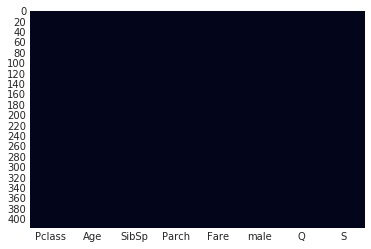

In [30]:
sns.heatmap(test.isnull(),cbar=False)

In [31]:
test.head()

,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,3,34.5,0,0,7.2500,1,1,0
1,3,47.0,1,0,71.2833,0,0,1
2,2,62.0,0,0,7.9250,1,1,0
3,3,27.0,0,0,53.1000,1,0,1
4,3,22.0,1,1,8.0500,0,0,1


In [32]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [33]:
X_train=train.drop('Survived',axis=1)
y_train=train['Survived']
X_test=test

In [34]:
logmodel=LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
pred=logmodel.predict(X_test)

In [36]:
len(pred)

418

we can then re-import the train data as predictions this time and add a survived column based on our pred values

In [37]:
predictions=pd.read_csv('../input/test.csv')

In [38]:
predictions['Survived']=pred

In [39]:
predictions.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


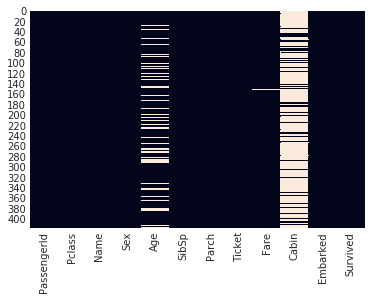

In [40]:
sns.heatmap(predictions.isnull(),cbar=False)

We can see from the above that their are no null values in the survived colum. 

In [41]:
predictions_formated=predictions.drop(['Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked'],axis=1)

In [42]:
predictions_formated.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [43]:
predictions_formated.to_csv('My_formated_titanic_predictions', index=False)